In [5]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 75.9 MB/s eta 0:00:00


In [1]:
import cv2
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load the image
img_path= '/content/drive/MyDrive/S5P_NO2_India_2019.png'
img = cv2.imread(img_path)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Compute the dark channel prior
patch_size = 15
dark_channel = np.zeros_like(gray)
for i in range(gray.shape[0]):
    for j in range(gray.shape[1]):
        patch = gray[max(i-patch_size//2,0):min(i+patch_size//2,gray.shape[0]),
                     max(j-patch_size//2,0):min(j+patch_size//2,gray.shape[1])]
        dark_channel[i,j] = np.min(patch)

# Estimate the atmospheric light
atmosphere = np.percentile(dark_channel, 99)

# Compute the transmission
transmission = 1 - 0.95*dark_channel/atmosphere

# Apply the soft matting algorithm
epsilon = 0.0001
window_size = 15
mean_filter = cv2.blur(transmission, (window_size, window_size))
mean_sqr_filter = cv2.blur(transmission**2, (window_size, window_size))
variance = mean_sqr_filter - mean_filter**2
a = variance / (variance + epsilon)
a = cv2.blur(a, (window_size, window_size))
transmission_matted = a*transmission + (1-a)*mean_filter

# High-pass filter the image using the transmission map
alpha = 0.1
img_filtered = img - cv2.GaussianBlur(img, (0, 0), np.mean(transmission_matted)*alpha)

# Add the filtered image to the original image
img_sharp = cv2.add(img, img_filtered)

# Save the sharpened image
cv2.imwrite('sharpened_image.png', img_sharp)


True

In [3]:
import pandas as pd

# Read the data from the CSV file
file_path='/content/drive/MyDrive/2019.xlsx'
df = pd.read_excel(file_path)

# Define a list of cities to consider
cities = ['Visakhapatnam', 'Vijayawada', 'Itanagar', 'Guwahati', 'Patna', 'Muzaffarpur', 'Bhagalpur', 'Raipur', 'Bilaspur', 'Bhilai Nagar', 'Panaji', 'Ahmedabad', 'Vadodara', 'Surat', 'Rajkot', 'Faridabad', 'Gurugram', 'Yamunanagar', 'Shimla', 'Baddi', 'Ranchi', 'Jamshedpur', 'Bengaluru', 'Mysuru', 'Mangaluru', 'Hubballi-Dharwad', 'Thiruvananthapuram', 'Kochi', 'Kozhikode', 'Indore', 'Bhopal', 'Gwalior', 'Mumbai', 'Pune', 'Imphal', 'Shillong', 'Aizawl', 'Dimapur', 'Bhubaneswar', 'Cuttack', 'Rourkela', 'Ludhiana', 'Jalandhar', 'Jaipur', 'Jodhpur', 'Udaipur', 'Gangtok', 'Chennai', 'Coimbatore', 'Madurai', 'Tiruchirappalli', 'Hyderabad', 'Warangal', 'Agartala', 'Dehradun', 'Haridwar', 'Nainital', 'Agra', 'Kanpur', 'Lucknow', 'Varanasi', 'Kolkata', 'Asansol', 'Durgapur', 'Haldia']

# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=['City', 'Annual Average'])

# Loop through each city and calculate the average annual average
for city in cities:
    city_data = df[df['City / town /village'] == city]
    avg_annual_avg = city_data['Annual Average'].mean()
    results = results.append({'City': city, 'NO_{2}': avg_annual_avg}, ignore_index=True)

# Save the results to a CSV file
results.to_csv('city_average_annual_avg2019.csv', index=False)

<ipython-input-3-62544a99a1e2>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'City': city, 'NO_{2}': avg_annual_avg}, ignore_index=True)
<ipython-input-3-62544a99a1e2>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'City': city, 'NO_{2}': avg_annual_avg}, ignore_index=True)
<ipython-input-3-62544a99a1e2>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'City': city, 'NO_{2}': avg_annual_avg}, ignore_index=True)
<ipython-input-3-62544a99a1e2>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'City': city, 'NO_{2}': avg_annual_a

In [6]:
import pandas as pd
import rasterio
file_path1 = '/content/drive/MyDrive/S5P_NO2_India_2021.tif'

with rasterio.open(file_path1) as src:
    raster_data = src.read(1)

city_df = pd.read_csv('/content/drive/MyDrive/Indian Cities Database.csv')

M = 46.0055 # Molar mass of NO2 in g/mol
V = 0.0002  # Vertical column density of NO2 in mol/m2

for index, row in city_df.iterrows():
    longitude = row['longitude']
    latitude = row['latitude']
    city_name = row['City']
    row, col = src.index(longitude, latitude)
    pixel_value = raster_data[row][col]
    NO2_concentration = (pixel_value * M) / V
    print(f'City: {city_name}, NO2 Concentration: {NO2_concentration} µg/m³')

City: Abohar, NO2 Concentration: 9.303556346070888 µg/m³
City: Adilabad, NO2 Concentration: 6.876245842827603 µg/m³
City: Agartala, NO2 Concentration: 9.606784465717825 µg/m³
City: Agra, NO2 Concentration: 15.311395666781806 µg/m³
City: Ahmadnagar, NO2 Concentration: 7.713540744758974 µg/m³
City: Ahmedabad, NO2 Concentration: 30.24594167002601 µg/m³
City: Aizawl  , NO2 Concentration: 4.3876709270838035 µg/m³
City: Ajmer, NO2 Concentration: 8.82588256801102 µg/m³
City: Akola, NO2 Concentration: 8.205245565135794 µg/m³
City: Alappuzha, NO2 Concentration: 4.652758416274094 µg/m³
City: Aligarh, NO2 Concentration: 14.455070629317726 µg/m³
City: Alipurduar, NO2 Concentration: 6.598693985000161 µg/m³
City: Allahabad, NO2 Concentration: 13.93029130631717 µg/m³
City: Alwar, NO2 Concentration: 9.610995523354399 µg/m³
City: Ambala, NO2 Concentration: 17.28149601219772 µg/m³
City: Amaravati, NO2 Concentration: 9.769249615739103 µg/m³
City: Amritsar, NO2 Concentration: 18.268919107302267 µg/m³
City

In [7]:
import pandas as pd
import rasterio

# Load air quality station data
station_data = pd.read_csv('/content/drive/MyDrive/Ind_SW_NO2.csv',encoding= 'unicode_escape')

# Load Sentinel data
file_path = '/content/drive/MyDrive/S5P_NO2_India_2019.tif'
with rasterio.open(file_path) as src:
    raster_data = src.read(1)

# Convert Sentinel pixel values to NO2 concentration
M = 46.0055 # Molar mass of NO2 in g/mol
V = 0.0002  # Vertical column density of NO2 in mol/m2
city_data = []
for index, row in station_data.iterrows():
    longitude = row['Longitude']
    latitude = row['Latitude']
    city_name = row['City']
    row, col = src.index(longitude, latitude)
    pixel_value = raster_data[row][col]
    NO2_concentration = (pixel_value * M) / V
    city_data.append([city_name, NO2_concentration])

# Create DataFrame from Sentinel data
sentinel_data = pd.DataFrame(city_data, columns=['City', 'Sentinel NO2 Reading_2019 (µg/m³)'])

# Merge air quality station data and Sentinel data
merged_data = pd.merge(station_data, sentinel_data, on='City')

# Calculate correlation between air quality station NO2 readings and Sentinel NO2 readings
correlation = merged_data['NO2 Reading_2019 (µg/m³)'].corr(merged_data['Sentinel NO2 Reading_2019 (µg/m³)'])

# Print correlation
print(f"Correlation between air quality station data and Sentinel data: {correlation}")


Correlation between air quality station data and Sentinel data: 0.5332283650110543


In [8]:
import pandas as pd
import rasterio

# Load air quality station data
station_data = pd.read_csv('/content/drive/MyDrive/Ind_SW_NO2.csv',encoding= 'unicode_escape')
station_data = station_data[['City', 'NO2 Reading_2019 (µg/m³)', 'Latitude', 'Longitude']]

# Load Sentinel data
file_path = '/content/drive/MyDrive/S5P_NO2_India_2019.tif'
with rasterio.open(file_path) as src:
    raster_data = src.read(1)

M = 46.0055 # Molar mass of NO2 in g/mol
V = 0.0002  # Vertical column density of NO2 in mol/m2

# Combine air quality station data with Sentinel data
for index, row in station_data.iterrows():
    city_name = row['City']
    latitude = row['Latitude']
    longitude = row['Longitude']
    row, col = src.index(longitude, latitude)
    pixel_value = raster_data[row][col]
    NO2_concentration = (pixel_value * M) / V
    station_NO2 = station_data.loc[index, 'NO2 Reading_2019 (µg/m³)']
    combined_NO2 = (station_NO2 + NO2_concentration) / 2
    station_data.at[index, 'NO2 Reading_2019 (µg/m³)'] = combined_NO2

# Save the combined data to a new file
station_data.to_excel('Combined_NO2_Data_2019.xlsx', index=False)

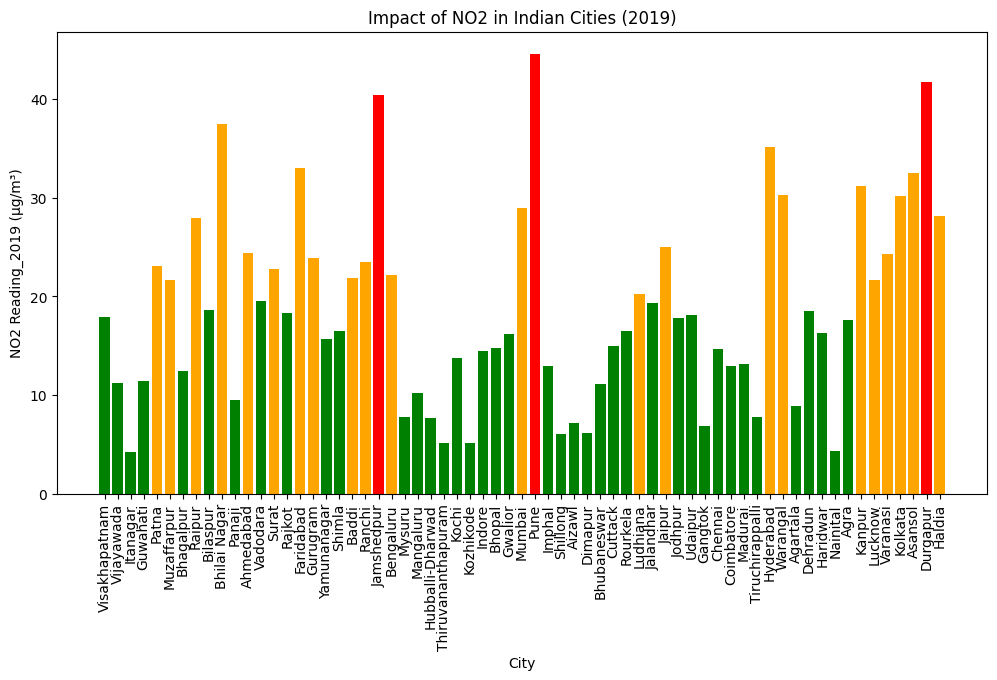

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load air quality station data
station_data = pd.read_excel('Combined_NO2_Data_2019.xlsx')
station_data = station_data[['City', 'NO2 Reading_2019 (µg/m³)', 'Latitude', 'Longitude']]

# Define impact levels based on NO2 readings
...


# Define impact levels based on NO2 readings
def impact_level(value):
    if value >= 40:
        return 'Highly impacted'
    elif value >= 20:
        return 'Moderately impacted'
    else:
        return 'Low impacted'

# Add a new column for impact level
station_data['Impact level'] = station_data['NO2 Reading_2019 (µg/m³)'].apply(impact_level)

# Plot the impact levels by city
plt.figure(figsize=(12,6))
plt.bar(station_data['City'], station_data['NO2 Reading_2019 (µg/m³)'], color=station_data['Impact level'].map({'Highly impacted': 'red', 'Moderately impacted': 'orange', 'Low impacted': 'green'}))
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('NO2 Reading_2019 (µg/m³)')
plt.title('Impact of NO2 in Indian Cities (2019)')
plt.show()


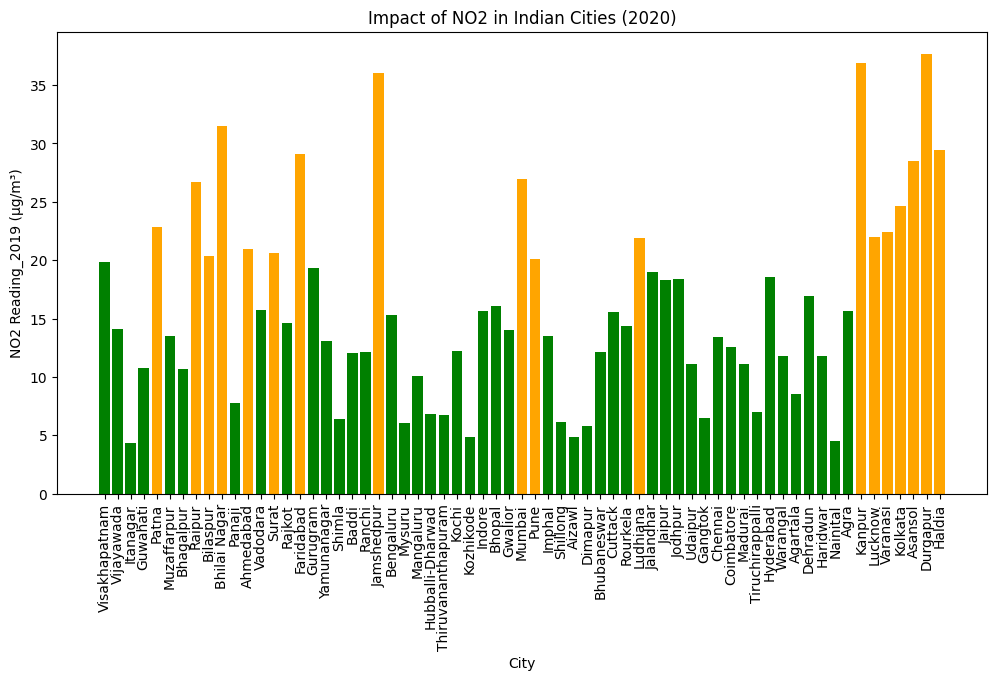

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load air quality station data
station_data = pd.read_excel('/content/drive/MyDrive/Combined_NO2_Data_2020.xlsx')
station_data = station_data[['City', 'NO2 Reading (µg/m³)', 'Latitude', 'Longitude']]


# Define impact levels based on NO2 readings
def impact_level(value):
    if value >= 40:
        return 'Highly impacted'
    elif value >= 20:
        return 'Moderately impacted'
    else:
        return 'Low impacted'

# Add a new column for impact level
station_data['Impact level'] = station_data['NO2 Reading (µg/m³)'].apply(impact_level)

# Plot the impact levels by city
plt.figure(figsize=(12,6))
plt.bar(station_data['City'], station_data['NO2 Reading (µg/m³)'], color=station_data['Impact level'].map({'Highly impacted': 'red', 'Moderately impacted': 'orange', 'Low impacted': 'green'}))
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('NO2 Reading_2019 (µg/m³)')
plt.title('Impact of NO2 in Indian Cities (2020)')
plt.show()


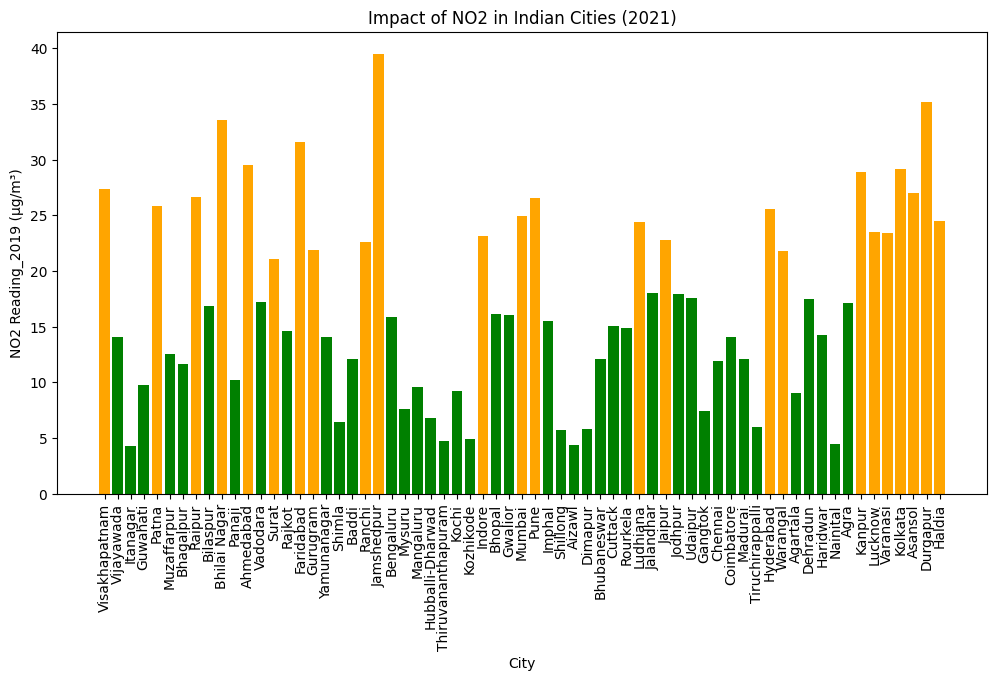

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load air quality station data
station_data = pd.read_excel('/content/drive/MyDrive/Combined_NO2_Data_2021.xlsx')
station_data = station_data[['City', 'NO2 Reading_2021 (µg/m³)', 'Latitude', 'Longitude']]


# Define impact levels based on NO2 readings
def impact_level(value):
    if value >= 40:
        return 'Highly impacted'
    elif value >= 20:
        return 'Moderately impacted'
    else:
        return 'Low impacted'

# Add a new column for impact level
station_data['Impact level'] = station_data['NO2 Reading_2021 (µg/m³)'].apply(impact_level)

# Plot the impact levels by city
plt.figure(figsize=(12,6))
plt.bar(station_data['City'], station_data['NO2 Reading_2021 (µg/m³)'], color=station_data['Impact level'].map({'Highly impacted': 'red', 'Moderately impacted': 'orange', 'Low impacted': 'green'}))
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('NO2 Reading_2019 (µg/m³)')
plt.title('Impact of NO2 in Indian Cities (2021)')
plt.show()


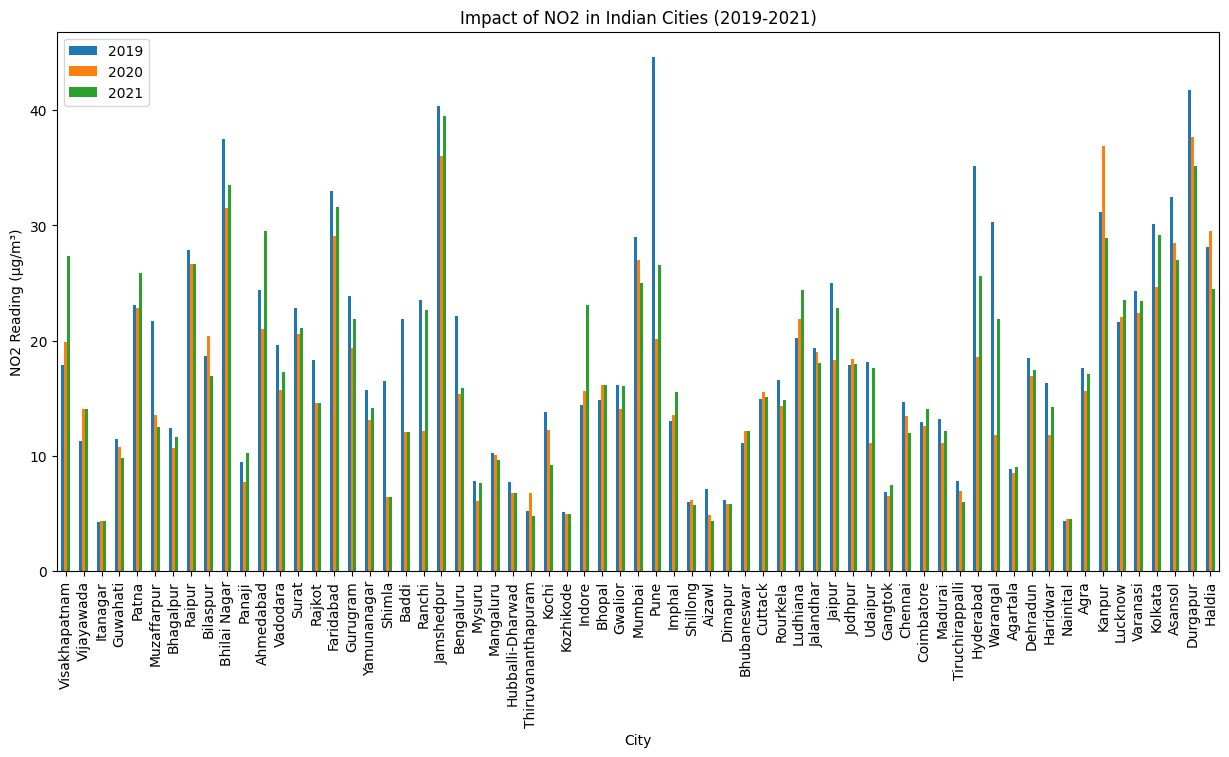

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load air quality station data for each year
data_2019 = pd.read_excel('Combined_NO2_Data_2019.xlsx')
data_2020 = pd.read_excel('/content/drive/MyDrive/Combined_NO2_Data_2020.xlsx')
data_2021 = pd.read_excel('/content/drive/MyDrive/Combined_NO2_Data_2021.xlsx')

# Merge data for all years into one dataframe
data = pd.merge(data_2019, data_2020, on='City', suffixes=('_2019', '_2020'))
data = pd.merge(data, data_2021, on='City', suffixes=('','_2021'))

# Select necessary columns
data = data[['City', 'NO2 Reading_2019 (µg/m³)', 'NO2 Reading (µg/m³)', 'NO2 Reading_2021 (µg/m³)']]

# Define impact levels based on NO2 readings
def impact_level(value):
    if value >= 40:
        return 'Highly impacted'
    elif value >= 20:
        return 'Moderately impacted'
    else:
        return 'Low impacted'

# Add impact level columns for each year
data['Impact level_2019'] = data['NO2 Reading_2019 (µg/m³)'].apply(impact_level)
data['Impact level_2020'] = data['NO2 Reading (µg/m³)'].apply(impact_level)
data['Impact level_2021'] = data['NO2 Reading_2021 (µg/m³)'].apply(impact_level)

# Set city as index
data = data.set_index('City')

# Plot a grouped bar chart for each year
data.plot(kind='bar', figsize=(15, 7))
plt.xlabel('City')
plt.ylabel('NO2 Reading (µg/m³)')
plt.title('Impact of NO2 in Indian Cities (2019-2021)')
plt.legend(['2019', '2020', '2021'])
plt.show()


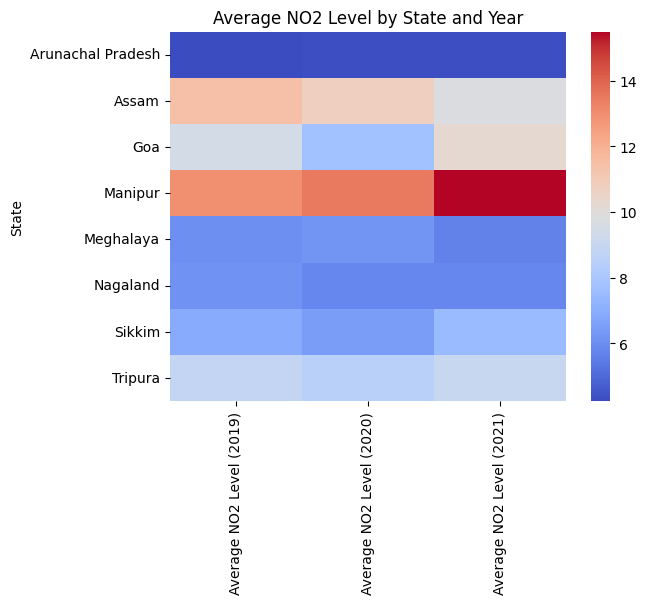

Highest average NO2 level by state:
State
Arunachal Pradesh     4.317776
Assam                11.446099
Goa                  10.230718
Manipur              15.498955
Meghalaya             6.177768
Nagaland              6.125036
Sikkim                7.467213
Tripura               9.002322
dtype: float64

Lowest average NO2 level by state:
State
Arunachal Pradesh     4.238407
Assam                 9.773614
Goa                   7.730718
Manipur              12.971575
Meghalaya             5.677768
Nagaland              5.812471
Sikkim                6.467213
Tripura               8.502322
dtype: float64


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load state-wise city data
state_data = pd.read_csv('/content/drive/MyDrive/State_City.csv', encoding='ISO-8859-1')

# Load air quality station data
aq_data_2019 = pd.read_excel('Combined_NO2_Data_2019.xlsx')
aq_data_2020 = pd.read_excel('/content/drive/MyDrive/Combined_NO2_Data_2020.xlsx')
aq_data_2021 = pd.read_excel('/content/drive/MyDrive/Combined_NO2_Data_2021.xlsx')

# Merge air quality station data with state-wise city data
aq_data_2019 = pd.merge(aq_data_2019, state_data, how='left', left_on='City', right_on='Cities')
aq_data_2020 = pd.merge(aq_data_2020, state_data, how='left', left_on='City', right_on='Cities')
aq_data_2021 = pd.merge(aq_data_2021, state_data, how='left', left_on='City', right_on='Cities')

# Define impact levels based on NO2 readings
def impact_level(value):
    if value >= 40:
        return 'Highly impacted'
    elif value >= 20:
        return 'Moderately impacted'
    else:
        return 'Low impacted'
# Group the data by state and year to get the average NO2 level for each state in each year
avg_aq_data_2019 = aq_data_2019.groupby(['State'])['NO2 Reading_2019 (µg/m³)'].mean().reset_index().rename(columns={'NO2 Reading_2019 (µg/m³)': 'Average NO2 Level (2019)'})
avg_aq_data_2020 = aq_data_2020.groupby(['State'])['NO2 Reading (µg/m³)'].mean().reset_index().rename(columns={'NO2 Reading (µg/m³)': 'Average NO2 Level (2020)'})
avg_aq_data_2021 = aq_data_2021.groupby(['State'])['NO2 Reading_2021 (µg/m³)'].mean().reset_index().rename(columns={'NO2 Reading_2021 (µg/m³)': 'Average NO2 Level (2021)'})
avg_aq_data = pd.merge(avg_aq_data_2019, avg_aq_data_2020, on='State')
avg_aq_data = pd.merge(avg_aq_data, avg_aq_data_2021, on='State')

# Visualize the data using a heat map
sns.heatmap(avg_aq_data.set_index('State'), cmap='coolwarm')
plt.title('Average NO2 Level by State and Year')
plt.show()

# Find the highest and lowest average NO2 level for each state across the three years
highest_avg = avg_aq_data.set_index('State').max(axis=1)
lowest_avg = avg_aq_data.set_index('State').min(axis=1)
print('Highest average NO2 level by state:')
print(highest_avg)
print('\nLowest average NO2 level by state:')
print(lowest_avg)